In [2]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [3]:
cd '/content/drive/My Drive/ssd'

/content/drive/My Drive/ssd_clone


In [ ]:
! git clone https://github.com/amdegroot/ssd.pytorch

Cloning into 'ssd.pytorch'...
remote: Enumerating objects: 1451, done.
remote: Total 1451 (delta 0), reused 0 (delta 0), pack-reused 1451
Receiving objects: 100% (1451/1451), 104.36 MiB | 16.10 MiB/s, done.
Resolving deltas: 100% (868/868), done.


In [4]:
cd '/content/drive/My Drive/ssd/ssd.pytorch'

/content/drive/My Drive/ssd_clone/ssd.pytorch


In [ ]:
!curl -LO http://host.robots.ox.ac.uk/pascal/VOC/voc2007/VOCtest_06-Nov-2007.tar

In [ ]:
!tar -xvf VOCtest_06-Nov-2007.tar

In [7]:
HOME='/content/drive/My Drive/ssd/ssd.pytorch'

In [14]:
from __future__ import print_function
import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
from data import VOC_ROOT, VOCAnnotationTransform, VOCDetection, BaseTransform
from data import VOC_CLASSES as labelmap
import torch.utils.data as data

from ssd import build_ssd

import sys
import os
import time
import argparse
import numpy as np
import pickle
import cv2
from PIL import Image


if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET


def str2bool(v):
    return v.lower() in ("yes", "true", "t", "1")

In [15]:
# to get the mean and standard deviation of the images
img_path="/content/drive/My Drive/ssd/ssd.pytorch/data/VOCdevkit/VOC2007/JPEGImages"

first_channel,second_channel,third_channel,num=[],[],[],0
for imgs in os.listdir(img_path):
    image_path=img_path +"/" +imgs
    img = np.array(PIL.Image.open(image_path).resize((244,244),Image.BILINEAR))
    first_channel.append(img[:,:,0])
    second_channel.append(img[:,:,1])
    third_channel.append(img[:,:,2])
    num+=1
    if num%50==0:
      print("image {} done".format(num))

mean,std=[np.mean(first_channel)/255.,np.mean(second_channel)/255.,np.mean(third_channel)/255.],[np.std(first_channel)/255.,np.std(second_channel)/255.,np.std(third_channel)/255.]
print(mean,std)

image 50 done
image 100 done
image 150 done
image 200 done
image 250 done
image 300 done
image 350 done
image 400 done
image 450 done
image 500 done
image 550 done
image 600 done
image 650 done
image 700 done
image 750 done
image 800 done
image 850 done
image 900 done
image 950 done
image 1000 done
image 1050 done
image 1100 done
image 1150 done
image 1200 done
image 1250 done
image 1300 done
image 1350 done
image 1400 done
image 1450 done
image 1500 done
image 1550 done
image 1600 done
image 1650 done
image 1700 done
image 1750 done
image 1800 done
image 1850 done
image 1900 done
image 1950 done
image 2000 done
image 2050 done
image 2100 done
image 2150 done
image 2200 done
image 2250 done
image 2300 done
image 2350 done
image 2400 done
image 2450 done
image 2500 done
image 2550 done
image 2600 done
image 2650 done
image 2700 done
image 2750 done
image 2800 done
image 2850 done
image 2900 done
image 2950 done
image 3000 done
image 3050 done
image 3100 done
image 3150 done
image 3200 d

In [16]:
# saving the results for future runs
MEAN,SD=[0.4484275876273171, 0.4253597920771978, 0.3917158653601366],[0.2684005844051463, 0.2653654130563566, 0.276699171437405]

In [17]:
VOC_ROOT='/content/drive/My Drive/ssd/ssd.pytorch/data/VOCdevkit/'

In [18]:
class arguments(object):
  def __init__(self,trained_model='weights/ssd300_mAP_77.43_v2.pth',save_folder='eval/',confidence_threshold=0.10,top_k=20,voc_root=VOC_ROOT,cuda=True,cleanup=True):
    self.trained_model=trained_model
    self.save_folder=save_folder
    self.confidence_threshold=confidence_threshold
    self.top_k=top_k
    self.voc_root=voc_root
    self.cuda=cuda
    self.cleanup=cleanup
args=arguments()

In [19]:
def base_transform(image,size,mean):
    x=cv2.resize(image,(size,size)).astype(np.float32)
    x-=mean
    x=x.astype(np.float32)
    return x

class BaseTransform:
    def __init__(self,size,mean):
        self.size=size
        self.mean=np.array(mean,dtype=np.float32)
    
    def __call__(self,image,boxes=None,labels=None):
        return base_transform(image,self.size,self.mean),boxes,labels

In [20]:
if not os.path.exists(args.save_folder):
    os.mkdir(args.save_folder)
    
if torch.cuda.is_available():
    if args.cuda:
        torch.set_default_tensor_type('torch.cuda.FloatTensor')
    else:
        print("Cuda device available but not utilised, Run with --cuda for faster speed")
else:
    torch.set_default_tensor_type('torch.FloatTensor')
    
anno_path=os.path.join(args.voc_root,'VOC2007','Annotations','%s.xml')
img_path=os.path.join(args.voc_root,'VOC2007','JPEGImages','%s.jpg')
img_set_path=os.path.join(args.voc_root,'VOC2007','ImageSets','Main','{:s}.txt')

YEAR='2007'
devkit_path=args.voc_root+'VOC'+YEAR
set_type='test'
MEANS=(104, 117, 123)

class Timer(object):
    def __init__(self):
        self.total_time=0.
        self.calls=0.
        self.start_time=0.
        self.diff=0.
        self.average_time=0.
    
    def tic(self):
        self.start_time=time.time()
        
    def toc(self,average=True):
        self.diff=time.time() - self.start_time
        self.total_time=+self.diff
        self.calls+=1
        self.average_time=self.total_time/self.calls
        if average:
            return self.average_time
        else:
            return self.diff
   
def parse_rec(filename):
    # To parse a PASCAL VOC xml file
    tree=ET.parse(filename)
    objects=[]
    for obj in tree.findall('object'):
        obj_struct={}
        obj_struct['name']=obj.find('name').text
        obj_struct['pose']=obj.find('pose').text
        obj_struct['truncated']=int(obj.find('truncated').text)
        obj_struct['difficult']=int(obj.find('difficult').text)
        bbox=obj.find('bndbox')
        obj_struct['bbox']=[int(bbox.find('xmin').text)-1,
                           int(bbox.find('xmax').text)-1,
                           int(bbox.find('ymin').text)-1,
                           int(bbox.find('ymax').text)-1,]
        objects.append(obj_struct)
        
    return objects

def get_output_dir(name,phase):
    """Returns the dir where expt artifacts are placed.
    if dir does not exist, will be created
    a canonical path will be built using the name from an imdb and a network(if not none)
    """
    filedir=os.path.join(name,phase)
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    return filedir

def get_voc_results_file_template(image_set,cls):
    #VOCdevkit/VOC2007/results/det_test_aeroplane.txt
    filename='det_' + image_set+'_%s.txt' %(cls)
    filedir=os.path.join(devkit_path,'results')
    if not os.path.exists(filedir):
        os.makedirs(filedir)
    path=os.path.join(filedir,filename)
    return path

def write_voc_results_file(all_boxes,dataset):
    for cls_ind,cls in enumerate(labelmap):
        print('Writing {:s} VOC results file'.format(cls))
        filename=get_voc_results_file_template(set_type,cls)
        with open(filename,'wt') as f:
            for im_ind,index in enumerate(dataset.ids):
              dets=all_boxes[cls_ind+1][im_ind] #get the bbox info at the current class and current image
              if dets==[]:
                continue
              #vocdevkit expects 1-based indices
              for k in range(dets.shape[0]):
                  f.write('{:s} {:3f} {:.1f} {:.1f} {:.1f} {:.1f}\n'.format(
                        index[1], dets[k,-1], dets[k,0]+1, dets[k,1] +1,
                        dets[k,2]+1,dets[k,3]+1 ))
            
def do_python_eval(output_dir='output',use_07=True):
    cachedir=os.path.join(devkit_path,'annotations_cache')
    aps=[]
    # pascal voc metric changed in 2010
    use_07_metric=use_07
    print('VOC07 metric?' + ('Yes' if use_07_metric else 'No'))
    if not os.path.isdir(output_dir):
        os.mkdir(output_dir)
    for i,cls in enumerate(labelmap):
        filename=get_voc_results_file_template(set_type,cls)
        #made changes to the img_set_path.format(set_type) to (cls + "_"+ set_type)
        rec,prec,ap=voc_eval(
            filename,anno_path,img_set_path.format(set_type),cls,cachedir,
            ovthresh=0.5,use_07_metric=use_07_metric)
        aps+=[ap]
        print('AP for {}={:.4f}'.format(cls,ap))
        #print('Recall for {}={:.4f}'.format(cls,int(rec)))
        #print('Precision for {}={:.4f}'.format(cls,int(prec)))
        with open(os.path.join(output_dir,cls+'_pr.pkl'),'wb') as f:
            pickle.dump({'rec':rec,'prec':prec,'ap':ap},f)
    print('Mean AP={:.4f}'.format(np.mean(aps)))

def voc_ap(rec,prec,use_07_metric=True):
    if use_07_metric:
        #11 point metric
        ap=0.
        for t in np.arange(0.,1.1,0.1):
            if np.sum(rec>=t)==0:
                p=0
            else:
                p= np.max(prec[rec>=t])
            ap=ap+p/11
    else:
        mrec=np.concatenate(([0.],rec,[1.]))
        mpre=np.concatenate(([0.],prec,[0.]))
        
        for i in range(mpre.size-1,0,-1):
            mpre[i-1]=np.maximum(mpre[i-1],mpre[i])
            
        #to calculate area under pr curve, look for points where x axis(recall) changes value
        i=np.where(mrec[1:] != mrec[:-1])[0] #next value !=prev value
        #sum (\Delta recall)*prec
        ap=np.sum((mrec[i+1]-mrec[i])* mpre[i+1])
    return ap

def voc_eval(detpath,annopath,imagesetfile,classname,cachedir,ovthresh=0.5,use_07_metric=True):
    #to evaluate for current class the rec,prec and ap
    
    #assumes detections are in detpath.format(classname)
    #assumes annotations are in annopath.format(imagename)
    #assumes imagesetfile is a textfile with each line an image name
    #cachedir caches the annotaions in a pickle file
    
    #first load the groundtruths
    if not os.path.isdir(cachedir):
        os.mkdir(cachedir)
    cachefile=os.path.join(cachedir,'annots.pkl')
    #read list of images
    with open(imagesetfile,'r') as f :
        lines=f.readlines()
    imagenames=[x.strip() for x in lines]
    
    if not os.path.isfile(cachefile):
        #load annotations
        recs={}
        for i,imagename in enumerate(imagenames):
            recs[imagename]=parse_rec(annopath%(imagename))
            if i%100==0:
                print('Reading annotation for {:d}/{:d}'.format(1+1,len(imagenames)))
        print('Saving cached annotations to {:s}'.format(cachefile))
        with open(cachefile,'wb') as f:
            pickle.dump(recs,f)
    else:
        with open(cachefile,'rb') as f:
            recs=pickle.load(f)
            
    #extract the gt object for this class
    class_recs={}
    npos=0
    for imagename in imagenames:
        R=[obj for obj in recs[imagename] if obj['name']==classname]  # R is the array of all the objects that belongs to category classname
        bbox=np.array([x['bbox'] for x in R])
        difficult=np.array([x['difficult'] for x in R]).astype(np.bool) 
        det=[False]*len(R)
        npos=npos+sum(~difficult) # sum(~difficult) gives us the number of difficult objects to detect in the image
        # ~ will negate the +1 of each element
        class_recs[imagename]={'bbox':bbox,
                              'difficult':difficult,
                              'det':det}
    
    #read dets
    detfile=detpath.format(classname)
    with open(detfile,'r') as f:
        lines=f.readlines()

    if any(lines)==1:
        splitlines=[x.strip().split(' ') for x in lines]
        image_ids=[x[0] for x in splitlines]
        confidence= np.array([float(x[1]) for x in splitlines])
        BB=np.array([[float(z) for z in x[2:]] for x in splitlines])

        #sort it by confidence
        sorted_ind=np.argsort(-confidence)
        sorted_scores=np.sort(-confidence)
        BB=BB[sorted_ind,:]
        image_ids=[image_ids[x] for x in sorted_ind]

        #go through the dets and mark TPs and FPs
        nd=len(image_ids)
        tp=np.zeros(nd)
        fp=np.zeros(nd)
        for d in range(nd): #go through all the images for this class
            R=class_recs[image_ids[d]]
            bb=BB[d,:].astype(float)
            ovmax=-np.inf
            BBGT=R['bbox'].astype(float)
            if BBGT.size>0:
                #compute overlaps, intersection
                ixmin=np.maximum(BBGT[:,0],bb[0])
                iymin=np.maximum(BBGT[:,1],bb[1])
                ixmax=np.minimum(BBGT[:,2],bb[2])
                iymax=np.minimum(BBGT[:,3],bb[3])
                iw=np.maximum(ixmax-ixmin,0.)
                ih=np.maximum(iymax-iymin,0.)
                intersection=iw*ih
                union=((bb[2]-bb[0])*(bb[3]-bb[1])+
                      (BBGT[:,2]-BBGT[:,0])* (BBGT[:,3]-BBGT[:,1]) - intersection)
                overlaps=intersection/union
                ovmax=np.max(overlaps)
                jmax=np.argmax(overlaps)
                
            if ovmax>ovthresh:
                if not R['difficult'][jmax]:
                    if not R['det'][jmax]:
                        tp[d]=1.
                        R['det'][jmax]=1
                    else:
                        fp[d]=1.
            else:
                fp[d] =1.
                
        #compute precision and recall
        fp=np.cumsum(fp)
        tp=np.cumsum(tp)
        rec= tp/float(npos)
        #to avoid division by 0 incase first detection matches a difficult
        prec=tp/np.maximum(tp+fp,np.finfo(np.float64).eps)
        ap=voc_ap(rec,prec,use_07_metric)
    else:
        rec=-1.
        prec=-1
        ac=-1
    return rec,prec,ap

def test_net_eval(save_folder,net,cuda,dataset,transform,top_k,im_size=300,thresh=0.05):
    #to evaluate for all classes 
    
    num_images=len(dataset)
    #all detections collected into:
    # all_boxes[cls][image]=Nx5 array of detections in (x1,y1,x2,y2,score)
    all_boxes=[[ [] for _ in range(num_images)] for _ in range(len(labelmap)+1)]
    
    #timers
    _t={'im_detect': Timer(), 'misc': Timer()}
    output_dir=get_output_dir('ssd300_120000',set_type)
    det_file=os.path.join(output_dir,'detections.pkl')
    
    for i in range(num_images):
        im,gt,h,w=dataset.pull_item(i)
        
        x=im.unsqueeze(0)
        if args.cuda:
            x=x.cuda()
        _t['im_detect'].tic()
        detections=net(x).data
        detect_time=_t['im_detect'].toc(average=False)
        
        #skip k=0 because it is background class
        #j= class index
        for j in range(1,detections.size(1)):  #go through all classes
            dets=detections[0,j,:]
            mask=dets[:,0].gt(0.).expand(5,dets.size(0)).t() #remove those that are background, ==0
            dets=torch.masked_select(dets,mask).view(-1,5)
            if dets.size(0)==0:
                continue
            boxes=dets[:,1:]
            boxes[:,0]*=w
            boxes[:,1]*=h
            boxes[:,2]*=w
            boxes[:,3]*=h
            
            scores=dets[:,0].cpu().numpy()
            cls_dets=np.hstack((boxes.cpu().numpy(),
                               scores[:,np.newaxis])).astype(np.float32,
                                                            copy=False)
            all_boxes[j][i]=cls_dets #j=class, i= curr image
        print('im_detect: {:d}/{:d} {:.3f}s'.format(i+1,num_images,detect_time))
        
    with open(det_file,'wb') as f:
        pickle.dump(all_boxes,f,pickle.HIGHEST_PROTOCOL)
        
    print('Evaluating detections')
    evaluate_detections(all_boxes,output_dir,dataset)

def evaluate_detections(box_list,output_dir,dataset):
    write_voc_results_file(box_list,dataset)
    do_python_eval(output_dir)
    
def eval():
    num_classes=len(labelmap) +1 
    net=build_ssd('test',300,num_classes)
    net.load_state_dict(torch.load(args.trained_model))
    net.eval()
    
    dataset=VOCDetection(args.voc_root,[('2007',set_type)],
                        BaseTransform(300,MEANS),
                        VOCAnnotationTransform())
    
    if args.cuda:
        net=net.cuda()
        cudnn.benchmark=True
        
    test_net_eval(args.save_folder,net,args.cuda,dataset,
                 BaseTransform(net.size,MEANS),args.top_k,300,thresh=0.01)

In [21]:
eval()

im_detect: 1/4952 3.695s
im_detect: 2/4952 0.050s
im_detect: 3/4952 0.051s
im_detect: 4/4952 0.056s
im_detect: 5/4952 0.063s
im_detect: 6/4952 0.053s
im_detect: 7/4952 0.050s
im_detect: 8/4952 0.050s
im_detect: 9/4952 0.068s
im_detect: 10/4952 0.084s
im_detect: 11/4952 0.071s
im_detect: 12/4952 0.069s
im_detect: 13/4952 0.070s
im_detect: 14/4952 0.101s
im_detect: 15/4952 0.071s
im_detect: 16/4952 0.068s
im_detect: 17/4952 0.067s
im_detect: 18/4952 0.069s
im_detect: 19/4952 0.068s
im_detect: 20/4952 0.073s
im_detect: 21/4952 0.068s
im_detect: 22/4952 0.069s
im_detect: 23/4952 0.071s
im_detect: 24/4952 0.068s
im_detect: 25/4952 0.074s
im_detect: 26/4952 0.069s
im_detect: 27/4952 0.089s
im_detect: 28/4952 0.068s
im_detect: 29/4952 0.069s
im_detect: 30/4952 0.079s
im_detect: 31/4952 0.082s
im_detect: 32/4952 0.071s
im_detect: 33/4952 0.068s
im_detect: 34/4952 0.068s
im_detect: 35/4952 0.074s
im_detect: 36/4952 0.083s
im_detect: 37/4952 0.068s
im_detect: 38/4952 0.071s
im_detect: 39/4952 0.

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:87: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.


Writing bicycle VOC results file
Writing bird VOC results file
Writing boat VOC results file
Writing bottle VOC results file
Writing bus VOC results file
Writing car VOC results file
Writing cat VOC results file
Writing chair VOC results file
Writing cow VOC results file
Writing diningtable VOC results file
Writing dog VOC results file
Writing horse VOC results file
Writing motorbike VOC results file
Writing person VOC results file
Writing pottedplant VOC results file
Writing sheep VOC results file
Writing sofa VOC results file
Writing train VOC results file
Writing tvmonitor VOC results file
VOC07 metric?Yes
AP for aeroplane=0.7946
AP for bicycle=0.8569
AP for bird=0.7545
AP for boat=0.6953
AP for bottle=0.4918
AP for bus=0.8470
AP for car=0.8585
AP for cat=0.8732
AP for chair=0.6136
AP for cow=0.8244
AP for diningtable=0.7904
AP for dog=0.8572
AP for horse=0.8714
AP for motorbike=0.8402
AP for person=0.7682
AP for pottedplant=0.5043
AP for sheep=0.7537
AP for sofa=0.7900
AP for train

In [22]:
from matplotlib import pyplot as plt
%matplotlib inline

In [23]:
num_classes=len(labelmap) +1 
net=build_ssd('test',300,num_classes)
net.load_state_dict(torch.load(args.trained_model))
net.eval()
net=net.cuda()

In [24]:
dataset=VOCDetection(args.voc_root,[('2007',set_type)],
                        BaseTransform(300,MEANS),
                        VOCAnnotationTransform())

((62.16511, 27.216715), 227.1754608154297, 210.8962860107422)
train: 1.00


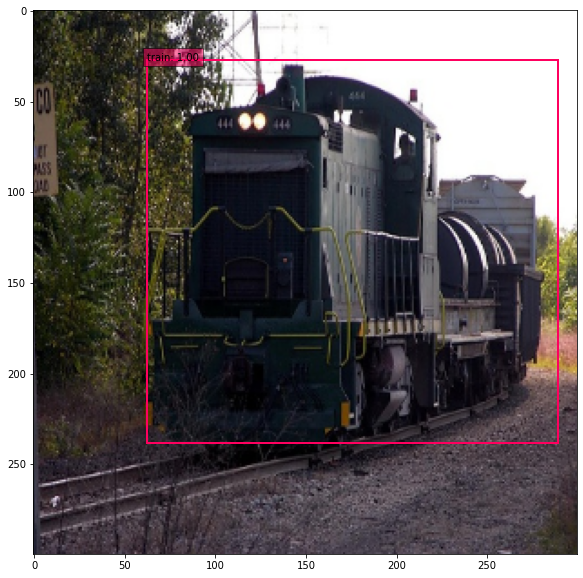

In [33]:
#plotting out the predictions
image,gt,w,h=dataset.pull_item(900)
image=dataset.pull_image(900)
image=cv2.resize(image, (300, 300))
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= MEANS
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
x = torch.from_numpy(x).permute(2, 0, 1)

x=x.cuda().unsqueeze(0)
start=time.time()
y=net(x)


labels=labelmap
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
myplot=plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] > 0.50:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        print(coords)
        print(display_txt)
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1


((58.800000000000004, 28.0), 222.39999999999998, 213.0)
train


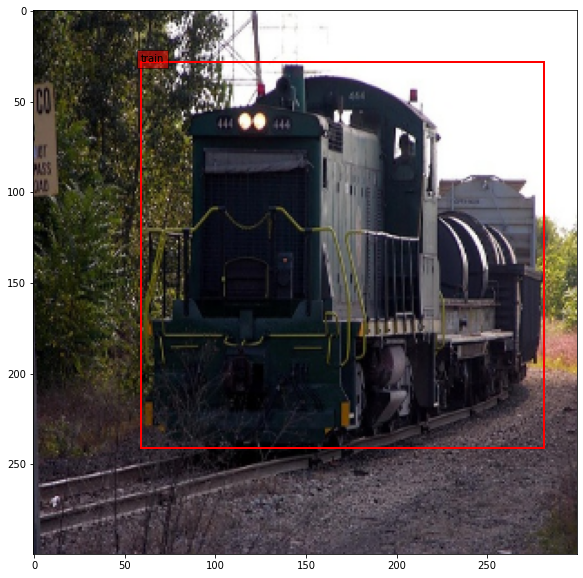

In [35]:
# plotting out the actual bounding boxes
actual=gt
labels=labelmap

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
myplot=plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(actual.shape[0]):
      label=actual[i][4]
      label_name = labels[int(label)]
      display_txt = '%s' %(label_name)
      pt = (torch.tensor(actual[i][:4])*scale).cpu().numpy()
      coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
      color = colors[i]
      print(coords)
      print(display_txt)
      currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
      currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})

References:

https://github.com/amdegroot/ssd.pytorch 